In [26]:
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from typing import Optional, Union
import seaborn as sns
import scipy
import bbknn
import harmonypy as hm
from scipy.spatial import distance
from scipy.spatial.distance import cdist
from scipy.io import mmread

In [2]:
import time

# Model

In [3]:
class TimeSeriesVAE(nn.Module):
    
    def __init__(self, input_dim, latent_dim=15):
        super(TimeSeriesVAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2)
        )
        
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def encode(self, x):
        enc = self.encoder(x)
        mu = self.fc_mu(enc)
        logvar = self.fc_logvar(enc)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        z, mu, logvar = self.encode(x)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

In [4]:
def vae_loss(recon_x, x, mu, logvar, beta=0.5):
    BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD

In [5]:
def train_vae(model, dataloader, epochs=100, lr=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data in dataloader:
            data = data[0].to(device)
            optimizer.zero_grad()
            
            recon_batch, mu, logvar = model(data)
            loss = vae_loss(recon_batch, data, mu, logvar)
            
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        
        avg_loss = train_loss / len(dataloader.dataset)
        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')
    
    return model

In [6]:
def save_model(model, adata, model_path='sc_vae_model.pth'):
    
    torch.save({
        'model_state_dict': model.state_dict(),
        'input_dim': model.encoder[0].in_features,
        'latent_dim': model.fc_mu.out_features
        }, model_path)
    
def load_model(model_path='sc_vae_model.pth', device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    checkpoint = torch.load(model_path, map_location=device)
    
    model = TimeSeriesVAE(
        input_dim=checkpoint['input_dim'],
        latent_dim=checkpoint['latent_dim']
    )
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    print(f"load from {model_path}")
    print(f"input dim: {checkpoint['input_dim']}, latent dim: {checkpoint['latent_dim']}")
    
    return model

In [7]:
def reduce_total_expression(matrix, target_sum=10000):
    matrix = matrix.T
    result_matrix = np.zeros_like(matrix) 
    
    for j in range(matrix.shape[1]):
        cell_data = matrix[:, j]
        
        sorted_indices = np.argsort(cell_data)[::-1]
        sorted_values = cell_data[sorted_indices]
        
        cumulative_sum = np.cumsum(sorted_values)
        k = np.argmax(cumulative_sum >= target_sum) + 1
        
        if k == 0 or cumulative_sum[k-1] < target_sum:
            k = len(sorted_values)
            
        top_indices = sorted_indices[:k]
        top_values = cell_data[top_indices]
        
        scale_factor = target_sum / np.sum(top_values)
        scaled_values = top_values * scale_factor
        result_matrix[top_indices, j] = scaled_values
    
    return result_matrix.T

# Data Setup

In [8]:
count_matrix = mmread('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/benchmark/source_matrix/CS10_CS12_2CS11_counts.mtx')
barcodes = pd.read_csv('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/benchmark/source_matrix/CS10_CS12_2CS11_cell.csv',index_col = 0)
gene_ids = pd.read_csv('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/benchmark/source_matrix/CS10_CS12_2CS11_gene.csv',index_col = 0)

In [8]:
count_matrix = mmread('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/benchmark/source_matrix/CS7_CS9_2CS8_counts.mtx')
barcodes = pd.read_csv('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/benchmark/source_matrix/CS7_CS9_2CS8_cell.csv',index_col = 0)
gene_ids = pd.read_csv('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/benchmark/source_matrix/CS7_CS9_2CS8_gene.csv',index_col = 0)

In [8]:
count_matrix = mmread('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/benchmark/source_matrix/CS9_CS11_2CS10_counts.mtx')
barcodes = pd.read_csv('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/benchmark/source_matrix/CS9_CS11_2CS10_cell.csv',index_col = 0)
gene_ids = pd.read_csv('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/benchmark/source_matrix/CS9_CS11_2CS10_gene.csv',index_col = 0)

In [8]:
count_matrix = mmread('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/benchmark/source_matrix/E10_E14_2E12_counts.mtx')
barcodes = pd.read_csv('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/benchmark/source_matrix/E10_E14_2E12_cell.csv',index_col = 0)
gene_ids = pd.read_csv('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/benchmark/source_matrix/E10_E14_2E12_gene.csv',index_col = 0)

In [8]:
count_matrix = mmread('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/benchmark/source_matrix/E12_CS7_2E14_counts.mtx')
barcodes = pd.read_csv('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/benchmark/source_matrix/E12_CS7_2E14_cell.csv',index_col = 0)
gene_ids = pd.read_csv('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/benchmark/source_matrix/E12_CS7_2E14_gene.csv',index_col = 0)

In [9]:
adata = an.AnnData(X = count_matrix.T.toarray(), obs = barcodes, var = gene_ids)
sc.pp.normalize_total(adata, target_sum=1e4)

In [10]:
#adata.obs['s_e'] = adata.obs.time.map({'CS10':'start','CS12':'end'})
#adata.obs['s_e'] = adata.obs.time.map({'CS7':'start','CS9':'end'})
adata.obs['s_e'] = adata.obs.time.map({'CS9':'start','CS11':'end'})
#adata.obs['s_e'] = adata.obs.time.map({'E10':'start','E14':'end'})
#adata.obs['s_e'] = adata.obs.time.map({'E12':'start','CS7':'end'})

In [29]:
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,cell_type,time,merge_type,s_e,n_zero_genes
AAACCCAAGCCAAGGT-1,0,1387.0,929,Heart progenitor,CS9,Mesoderm,start,0.984000
AAACCCAAGGTAGTCG-1,0,526.0,414,ExE mesoderm,CS9,YolkSac,start,0.984500
AAACCCACAACGCATT-1,0,7364.0,3806,YS mesoderm,CS9,YolkSac,start,0.921625
AAACCCACAATCTCGA-1,0,3127.0,1946,Surface ectoderm,CS9,Ectoderm,start,0.964125
AAACCCACACATCATG-1,0,2073.0,1339,Endothelium,CS9,Mesoderm,start,0.973500
...,...,...,...,...,...,...,...,...
CAGTTCCAGCCTTGAT-1_2,CS11_RNA2,1071.0,720,Spinal cord,CS11,Ectoderm,end,0.984625
CAGGTATTCTCTGGTC-1_2,CS11_RNA2,2275.0,1323,Limb progenitor,CS11,Mesoderm,end,0.974375
GATTTCTGTACCTTCC-1_2,CS11_RNA2,1599.0,1019,Splanchnic LPM,CS11,Mesoderm,end,0.980500
CTCAAGAAGCTTCGTA-1_1,CS11_RNA1,1602.0,1122,Spinal cord,CS11,Ectoderm,end,0.976875


# Simulation

In [12]:
re_modelsetup_s = time.localtime()
dataset = TensorDataset(torch.tensor(np.array(adata.X), dtype=torch.float32))
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

input_dim = torch.tensor(np.array(adata.X), dtype=torch.float32).shape[1]
model = TimeSeriesVAE(input_dim, latent_dim=15)
re_modelsetup_e = time.localtime()

In [13]:
torch.manual_seed(42)
re_modeltrain_s = time.localtime()
trained_model = train_vae(model, dataloader, epochs=50, lr=1e-4)
re_modeltrain_e = time.localtime()

Epoch 10/50, Loss: 12502399.0706
Epoch 20/50, Loss: 12502220.3888
Epoch 30/50, Loss: 12502117.2819
Epoch 40/50, Loss: 12502037.5783
Epoch 50/50, Loss: 12501979.6249


In [14]:
save_model(trained_model, adata, '/slurm/home/yrd/liaolab/caohaoxue/embryo_work/benchmark/simulated_matrix/CS10f_CytO.pth')

In [27]:
model = load_model('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/benchmark/simulated_matrix/CS10f_CytO.pth')

已从 /slurm/home/yrd/liaolab/caohaoxue/embryo_work/benchmark/simulated_matrix/CS10f_CytO.pth 加载模型
输入维度: 8000, 潜在空间维度: 15


In [28]:
re_sim_s = time.localtime()

device = next(model.parameters()).device

t1_tensor = torch.tensor(adata[adata.obs.s_e=='start'].X, dtype=torch.float32).to(device)
t2_tensor = torch.tensor(adata[adata.obs.s_e=='end'].X, dtype=torch.float32).to(device)

torch.manual_seed(42)
with torch.no_grad():
        z_t1, _, _ = model.encode(t1_tensor)
        z_t2, _, _ = model.encode(t2_tensor)
        
latent_s = z_t1.cpu().numpy()
latent_e = z_t2.cpu().numpy()
latent_s = pd.DataFrame(data = latent_s, index = adata[adata.obs.s_e=='start'].obs.index)
latent_e = pd.DataFrame(data = latent_e, index = adata[adata.obs.s_e=='end'].obs.index)

distances = distance.cdist(latent_s, latent_e, metric='euclidean')
distances = pd.DataFrame(index = adata[adata.obs.s_e=='start'].obs.index, columns = adata[adata.obs.s_e=='end'].obs.index, data = distances)
min_dis = distances.idxmin().to_dict()
latent_mid = pd.DataFrame(latent_e.columns).T
for key,value in min_dis.items():
    cell_end = latent_e.loc[key]
    cell_start = latent_s.loc[value]
    cell_mid = pd.DataFrame((cell_end + cell_start)/2)
    latent_mid = np.vstack((latent_mid, cell_mid.T))
latent_mid = latent_mid[1:, :]

z_mid = torch.tensor(latent_mid, dtype=torch.float32).to(device)
torch.manual_seed(42)
with torch.no_grad():
    mid_cell = model.decode(z_mid).cpu().numpy()
    
re_sim_e = time.localtime()

In [34]:
name = new_list = [s[:-1] + "CS10-CytO" if s else s for s in adata[adata.obs.s_e == 'end'].obs.index]

adata_interpolated = sc.AnnData(X=pd.DataFrame(data = mid_cell,
                                              index = adata[adata.obs.s_e == 'end'].obs.index,
                                              columns = adata[adata.obs.s_e == 'end'].var.index),
                               obs = adata[adata.obs.s_e == 'end'].obs)

adata_interpolated.var['features'] = adata_interpolated.var.index

adata_interpolated.obs.time = 'CS10-CytOrigin'
adata_interpolated.obs.s_e = 'mid'
adata_interpolated.obs.index = name

In [18]:
adata_interpolated.obs

,orig.ident,nCount_RNA,nFeature_RNA,cell_type,time,merge_type,s_e
TGGTACATCGCTGTCT-1_CS10-CytO,CS11_RNA2,1505.0,1045,Mesenchyme,CS10-CytOrigin,Mesoderm,mid
CTTTCAAAGAGAATCT-1_CS10-CytO,CS11_RNA2,859.0,677,Somites,CS10-CytOrigin,Mesoderm,mid
GTCGAATTCGCAAGAG-1_CS10-CytO,CS11_RNA2,1544.0,1088,Limb progenitor,CS10-CytOrigin,Mesoderm,mid
TACCTTTAGGATAAAC-1_CS10-CytO,CS11_multi_RNA,3535.0,1959,PSM,CS10-CytOrigin,Mesoderm,mid
GTCATTTGTACTCGAT-1_CS10-CytO,CS11_RNA1,731.0,585,Neural progenitor-PAX6+,CS10-CytOrigin,Ectoderm,mid
...,...,...,...,...,...,...,...
CAGTTCCAGCCTTGAT-1_CS10-CytO,CS11_RNA2,1071.0,720,Spinal cord,CS10-CytOrigin,Ectoderm,mid
CAGGTATTCTCTGGTC-1_CS10-CytO,CS11_RNA2,2275.0,1323,Limb progenitor,CS10-CytOrigin,Mesoderm,mid
GATTTCTGTACCTTCC-1_CS10-CytO,CS11_RNA2,1599.0,1019,Splanchnic LPM,CS10-CytOrigin,Mesoderm,mid
CTCAAGAAGCTTCGTA-1_CS10-CytO,CS11_RNA1,1602.0,1122,Spinal cord,CS10-CytOrigin,Ectoderm,mid


/tmp/ipykernel_30545/3471468414.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


<Axes: xlabel='time', ylabel='n_zero_genes'>

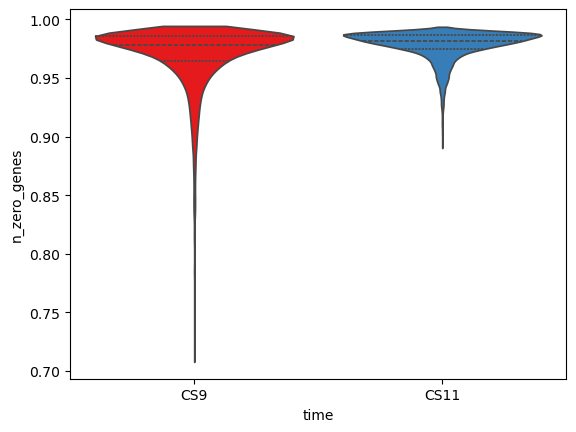

In [19]:
X = adata.X
zeros_per_cell = (X == 0).sum(axis=1)/len(adata.var.index)
adata.X.sum(axis = 1)
adata.obs['n_zero_genes'] = zeros_per_cell
sns.violinplot(
    x="time",
    y="n_zero_genes",
    data=adata.obs,
    inner="quartile",
    cut=0,
    saturation=1
)

/tmp/ipykernel_30545/404377762.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


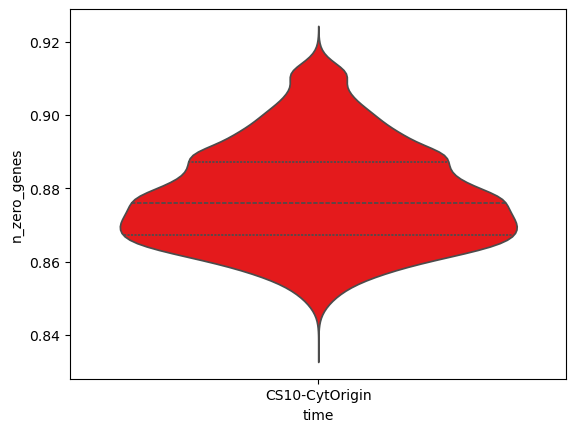

In [35]:
re_cor_s = time.localtime()
sc.pp.normalize_total(adata_interpolated, target_sum=2.4e4)
adata_interpolated.X = reduce_total_expression(adata_interpolated.X, target_sum=1e4)

X = adata_interpolated.X
zeros_per_cell = (X == 0).sum(axis=1)/len(adata_interpolated.var.index)
adata_interpolated.X.sum(axis = 1)
adata_interpolated.obs['n_zero_genes'] = zeros_per_cell

sns.violinplot(
    x="time",
    y="n_zero_genes",
    data=adata_interpolated.obs,
    palette="Set1",
    inner="quartile",
    cut=2,
    saturation=1
)
re_cor_e = time.localtime()

# Output

In [24]:
time_records = pd.DataFrame(data = [re_modelsetup_s,re_modelsetup_e,re_modeltrain_s,re_modeltrain_e,re_sim_s,re_sim_e,re_cor_s,re_cor_e],
                           index = ['modelsetup_s','modelsetup_e','modeltrain_s','modeltrain_e','simulation_s','simulation_e','correction_s','correction_e'],
                           columns = ['year', 'mon', 'mday', 'hour', 'min', 'sec', 'wday', 'yday', 'isdst'])

In [24]:
adata_interpolated.obs = adata_interpolated.obs.drop(columns = 'orig.ident')

In [25]:
adata_interpolated.obs = adata_interpolated.obs.drop(columns = 'batch')

In [25]:
time_records.to_csv('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/benchmark/simulated_matrix/CS10f_CytO_time.csv')
adata_interpolated.write_h5ad('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/benchmark/simulated_matrix/h5ad_format/CS10f_CytO.h5ad')